In [25]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np 
import glob
import nibabel as nb
import itertools
import json
import sys
import statsmodels.api as sm
from statsmodels.formula.api import ols, wls
from statsmodels.formula.api import mixedlm
from patsy.contrasts import Treatment

from scipy import stats
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LinearRegression
from statsmodels.sandbox.regression.predstd import wls_prediction_std
from statsmodels.iolib.table import (SimpleTable, default_txt_fmt)

from sklearn.feature_selection import SelectKBest, SelectPercentile
from sklearn.feature_selection import f_regression, mutual_info_regression

import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
np.random.seed(1024)

In [3]:
base_dir = '/home/abhijit/Jyotirmay/my_thesis'

In [4]:
smoking_feats = ['smoker_former', 'smoker_irregular', 'smoker_non_smoker', 'smoker_regular', 'smoking-packages']
bmi_feats = ['bmi-who_normal', 'bmi-who_obesity class I', 'bmi-who_obesity class II', 'bmi-who_obesity class III',
            'bmi_numeric', 'bmi-who_pre-obisety']
blood_pressure_feats = ['blood-pressure-diastolic', 'blood-pressure-systolic']
cholesterol_feats = ['cholesterol-hdl', 'cholesterol-ldl', 'cholesterol-total']
mri_feats = ['mri-liver-fat-artifacts', 'mri-liver-fat-lobus-dexter', 
             'mri-liver-fat-lobus-sinister', 'mri-liver-fat-portal-vein']
alcohol_feats = ['alcohol-g/day']
hbalc_feats = ['hba1c-mmol/mol', 'hba1c-percentage']
medication_feats = ['meds-antidiabetic', 'meds-antihypertensive', 'meds-incretin-mimetics', 'meds-insulin-therapy',
                    'meds-lipoprotein-lowering', 'meds-oral-antidiabetic']
triglyceride = ['triglyceride']
hypertension = ['hypertension']
basic_feats = ['age', 'height', 'sex', 'weight']

vols_feat = ['seg_liver', 'seg_spleen']
spleen_sample_cols = ['0_spleen','1_spleen','2_spleen','3_spleen','4_spleen','5_spleen','6_spleen','7_spleen','8_spleen','9_spleen']
liver_sample_cols = ['0_liver','1_liver','2_liver','3_liver','4_liver','5_liver','6_liver','7_liver','8_liver','9_liver']

feats_from_paper_for_group_test = [['age', 'sex_0', 'sex_1', 'bmi_numeric'],
             ['diabetes_status_0', 'diabetes_status_1', 'diabetes_status_2'], ['hypertension'], ['triglyceride'],
             ['cholesterol_hdl', 'cholesterol_ldl'],
             ['mri_liver_fat_artifacts', 'mri_liver_fat_lobus_dexter', 
              'mri_liver_fat_lobus_sinister', 'mri_liver_fat_portal_vein'],
             ['meds_lipoprotein_lowering'],
             ['smoker_former', 'smoker_non_smoker', 'smoker_regular']]

feats_from_paper_for_individual_test = [['age', 'sex_0', 'sex_1', 'bmi_numeric'],
             ['diabetes_status_0', 'diabetes_status_1', 'diabetes_status_2'], ['hypertension'], ['triglyceride'],
             ['blood_pressure_diastolic', 'blood_pressure_systolic'],
             ['cholesterol_hdl', 'cholesterol_ldl', 'cholesterol_total'],
             ['mri_liver_fat_artifacts', 'mri_liver_fat_lobus_dexter', 
              'mri_liver_fat_lobus_sinister', 'mri_liver_fat_portal_vein'],
             ['meds_lipoprotein_lowering', 'meds_antihypertensive'],
             ['smoker_former', 'smoker_non_smoker', 'smoker_regular'], ['alcohol_g_day']]

feats_from_paper_for_individual_test_ukb = [['age', 'sex', 'bmi_numeric'],
             ['diabetes_status']]

paper_link = 'https://journals.plos.org/plosone/article/file?id=10.1371/journal.pone.0177154&type=printable'

In [5]:
model_merged_feats_path = [
    {'full_bayesian': './projects/full_bayesian/reports/full_bayesian_KORA_v2/KORA/10_1571866968.4002764_concat_report_final.csv'},
    {'full_bayesian_0dot01': './projects/full_bayesian/reports/full_bayesian_KORA_v4/KORA/10_1572514598.527084_concat_report_final.csv'},
    {'MC_dropout_quicknat': './projects/MC_dropout_quicknat/reports/MC_dropout_quicknat_KORA_v2/KORA/10_1572006141.7793334_concat_report_final.csv'}, 
    {'probabilistic_quicknat': './projects/probabilistic_quicknat/reports/probabilistic_quicknat_KORA_v2/KORA/10_1571996796.7963011_concat_report_final.csv'}, 
    {'hierarchical_quicknat': './projects/hierarchical_quicknat/reports/hierarchical_quicknat_KORA_v2/KORA/10_1571905560.9377904_concat_report_final.csv'}
]
all_dataset_merged_feats_path = [
    {'all_KORA_processed_False': '/home/abhijit/Jyotirmay/my_thesis/dataset_groups/whole_body_datasets/KORA/all_processed_False_concat_report_final.csv'}, 
    {'all_KORA_processed_True': '/home/abhijit/Jyotirmay/my_thesis/dataset_groups/whole_body_datasets/KORA/all_processed_True_concat_report_final.csv'}
]

test_dataset_merged_feats_path = [
    {'test_KORA_processed_False': '/home/abhijit/Jyotirmay/my_thesis/dataset_groups/whole_body_datasets/KORA/test_processed_False_concat_report_final.csv'}, 
    {'test_KORA_processed_True': '/home/abhijit/Jyotirmay/my_thesis/dataset_groups/whole_body_datasets/KORA/test_processed_True_concat_report_final.csv'}
]

all_paths = [
    {'full_bayesian': './projects/full_bayesian/reports/full_bayesian_KORA_v2/KORA/10_1571866968.4002764_concat_report_final.csv'},
    {'full_bayesian_0dot01': './projects/full_bayesian/reports/full_bayesian_KORA_v4/KORA/10_1572514598.527084_concat_report_final.csv'},
    {'MC_dropout_quicknat': './projects/MC_dropout_quicknat/reports/MC_dropout_quicknat_KORA_v2/KORA/10_1572006141.7793334_concat_report_final.csv'}, 
    {'probabilistic_quicknat': './projects/probabilistic_quicknat/reports/probabilistic_quicknat_KORA_v2/KORA/10_1571996796.7963011_concat_report_final.csv'}, 
    {'hierarchical_quicknat': './projects/hierarchical_quicknat/reports/hierarchical_quicknat_KORA_v2/KORA/10_1571905560.9377904_concat_report_final.csv'},
    {'all_KORA_processed_False': '/home/abhijit/Jyotirmay/my_thesis/dataset_groups/whole_body_datasets/KORA/all_processed_False_concat_report_final.csv'}, 
    {'all_KORA_processed_True': '/home/abhijit/Jyotirmay/my_thesis/dataset_groups/whole_body_datasets/KORA/all_processed_True_concat_report_final.csv'},
    {'test_KORA_processed_False': '/home/abhijit/Jyotirmay/my_thesis/dataset_groups/whole_body_datasets/KORA/test_processed_False_concat_report_final.csv'}, 
    {'test_KORA_processed_True': '/home/abhijit/Jyotirmay/my_thesis/dataset_groups/whole_body_datasets/KORA/test_processed_True_concat_report_final.csv'}
]

final_model_report_path = [
    {'full_bayesian': './projects/full_bayesian/reports/full_bayesian_KORA_v2/KORA/10_1571866968.4002764_final_report.csv'},
    {'full_bayesian_0dot01': './projects/full_bayesian/reports/full_bayesian_KORA_v4/KORA/10_1572514598.527084_final_report.csv'},
    {'MC_dropout_quicknat': './projects/MC_dropout_quicknat/reports/MC_dropout_quicknat_KORA_v2/KORA/10_1572006141.7793334_final_report.csv'}, 
    {'probabilistic_quicknat': './projects/probabilistic_quicknat/reports/probabilistic_quicknat_KORA_v2/KORA/10_1571996796.7963011_final_report.csv'}, 
    {'hierarchical_quicknat': './projects/hierarchical_quicknat/reports/hierarchical_quicknat_KORA_v2/KORA/10_1571905560.9377904_final_report.csv'}
]

ukb_paths = [
    {'MC_dropout_quicknat': './projects/MC_dropout_quicknat/reports/MC_dropout_quicknat_UKB_v2/UKB/10_1573078374.453554_concat_report_final.csv'}
]

fb = 'full_bayesian'
fb01 = 'full_bayesian_0dot01'
mc = 'MC_dropout_quicknat'
pq = 'probabilistic_quicknat'
hq = 'hierarchical_quicknat'
af = 'all_KORA_processed_False'
at = 'all_KORA_processed_True'
tf = 'test_KORA_processed_False'
tt = 'test_KORA_processed_True'

In [6]:
flatten = lambda l: [item for sublist in l for item in sublist]

def transform_to_categorical(df, categorical_features_list):
    for f in categorical_features_list:
        dfDummies = pd.get_dummies(df[f], prefix = f)
        df = pd.concat([df, dfDummies], axis=1)
    return df

def rename(df, cols_map=None):
    if cols_map is None:
        cols_map =  {'bmi-numeric':'bmi_numeric', 'blood-pressure-diastolic':'blood_pressure_diastolic', 'blood-pressure-systolic':'blood_pressure_systolic',
             'cholesterol-hdl':'cholesterol_hdl', 'cholesterol-ldl':'cholesterol_ldl', 'cholesterol-total':'cholesterol_total',
             'mri-liver-fat-artifacts':'mri_liver_fat_artifacts', 'mri-liver-fat-lobus-dexter':'mri_liver_fat_lobus_dexter', 
              'mri-liver-fat-lobus-sinister':'mri_liver_fat_lobus_sinister', 'mri-liver-fat-portal-vein':'mri_liver_fat_portal_vein',
             'meds-lipoprotein-lowering':'meds_lipoprotein_lowering', 'meds-antihypertensive':'meds_antihypertensive',
              'smoker_non-smoker':'smoker_non_smoker','alcohol-g/day':'alcohol_g_day'}
    df.rename(columns=cols_map, inplace=True)
    return df

def z_score_column_normalise(df, column_list):
    normalised_cols_map = {}
    for column in column_list:
        normalised_cols_map[column] = column+'_normalised'
        df[normalised_cols_map[column]] = (df[column] - df[column].mean())/df[column].std(ddof=0)
    return df, normalised_cols_map

def z_score_group_normalise(df, cols_to_normalise):
    normalised_cols_map = {}
    group_cols_value = df[cols_to_normalise].values
    mean, std = np.mean(group_cols_value), np.std(group_cols_value, ddof=0)
    for column in cols_to_normalise:
        normalised_cols_map[column] = column+'_normalised'
        df[normalised_cols_map[column]] = (df[column] - mean)/std
    return df, normalised_cols_map

def pre_process_for_mlm(df, to_be_transpose_cols, value_name):
    cols = list(df.columns)
    cols_without_tobe_transposed_cols = list(set(cols) - set(to_be_transpose_cols))
    df = df.melt(id_vars=cols_without_tobe_transposed_cols, 
            value_vars=to_be_transpose_cols, 
            value_name=value_name)

    return df

In [7]:
def split_diabetes_state(df):
    df_normal = df[df['diabetes_status']==0]
    df_pre_diabetic = df[df['diabetes_status']==1]
    df_diabetic = df[df['diabetes_status']==2]
    df_normal_affx = df_normal.rename(columns=lambda x: 'normal_'+x)
    df_pre_diabetic_affx = df_pre_diabetic.rename(columns=lambda x: 'pre_diabetic_'+x)
    df_diabetic_affx = df_diabetic.rename(columns=lambda x: 'diabetic_'+x)
    dfs = pd.concat([df_normal_affx, df_pre_diabetic_affx, df_diabetic_affx])
    return dfs

def plot_and_ttest(df, cols):
    dicts = {}
    for col_subset in itertools.combinations(cols, 2):
        print(f'{col_subset[0]} vs {col_subset[1]}')
        df[list(col_subset)].boxplot(rot=45)
        t,p = stats.ttest_ind(df[col_subset[0]].dropna().values, df[col_subset[1]].dropna().values)

        print('ttest_score:', t)
        print('p_value:', p)
        print('\n')
        dicts[f'{col_subset[0]} vs {col_subset[1]}'] = p
        plt.show()
    return dicts

In [8]:
def model_evaluation_matrics(file_paths_dict, cols_to_fetch):
    dicts = {}
    for model, path in file_paths_dict.items():
        df = pd.read_csv(path)
        dicts[model] = df[cols_to_fetch].iloc[1].values
    return dicts

In [100]:
def individual_feature_stats(feats, df, target_col):
    p_values = {}
    y = df[target_col].copy()
    y_classes = y.values
    for f in feats:
        try:
            X = pd.get_dummies(df.loc[y.index, [f]], drop_first=True)
            mod = sm.OLS(y_classes, X)
            fii = mod.fit()
#             is_significant = True if fii.pvalues.values[0] < 0.05 else False
            p_values[f] = fii.pvalues.values[0]
        except Exception as e:
            print(e)

    return p_values

In [10]:
from patsy.contrasts import Treatment
significance_check = lambda x: False if x>0.05 else True
def group_feature_stats(feats, df, target_col):
    p_values, fii = None, None
    y = df[target_col].copy()
    y_classes = y.values
    try:
        X = pd.get_dummies(df.loc[y.index, feats], drop_first=True)
        mod = sm.OLS(y_classes, X)
        fii = mod.fit()
#         print(fii.summary())
#         df_fii = pd.read_html(fii.summary().tables[1].as_html(),header=0,index_col=0)[0]
#         print(fii.pvalues.values[0], fii.params.values)
#         is_significant_list = [significance_check(p_value) for p_value in fii.pvalues.values]   
        p_values = fii.pvalues.values
    except Exception as e:
        print(e)
        
    return p_values, fii


In [11]:


def normal_group_fit(df, target_col, features_string):
    model = ols(f'{target_col} ~ {features_string}', df).fit()
    plot_model_outputs(df['bmi_numeric'].values, df[target_col].values, model, 'OLS')
    return model

def weighted_group_feats(df, target_col, features_string, alpha_col):
    alpha = df[alpha_col].values
    model = wls(f'{target_col} ~ {features_string}', df, weights=alpha).fit()
    df_ = df.sort_values('diabetes_status')
    plot_model_outputs(df_['diabetes_status'].values, df_[target_col].values, model, 'WLS', df_)
    model = ols(f'{target_col} ~ {features_string}', df).fit()
    plot_model_outputs(df_['diabetes_status'].values, df_[target_col].values, model, 'OLS', df_)
#     model = ols(f'{target_col} ~ {features_string}', df).fit_regularized(alpha=alpha, L1_wt=L1_wt)
    return model

def normal_mixed_effect_model(df, target_col, features_string, group_col, L1_wt=None):
    if L1_wt is None:
        model = mixedlm(f'{target_col} ~ {features_string}', df, groups=df[group_col]).fit()
    else:
        model = mixedlm(f'{target_col} ~ {features_string}', df, groups=df[group_col]).fit_regularized(L1_wt=L1_wt)
    return model

def anova_test(ols_model):
    anova_stats = sm.stats.anova_lm(ols_model)
    return anova_stats

In [12]:
def gathering_p_values():
    pass

In [13]:
def df_from_nested_dicts(dicts):
    df = pd.concat({k+'_'+kk: pd.concat({kk:pd.DataFrame(vv).T}, axis=0) for k, v in dicts.items() for kk, vv in v.items()}, axis=0)
    return df

def df_from_nested_dicts_group(dicts):
    df = pd.concat({k+'_'+kk: pd.concat({kk:pd.DataFrame(vv).T}, axis=0) for k, v in dicts.items() for kk, vv in v.items()}, axis=0)
    return df

def highlight_significance(df):
    return df.style.applymap(lambda x: 'background-color : yellow' if x==True or x<0.05 else '')

In [14]:
model_merged_feats_path_combined = {key:val for d in all_paths for key,val in d.items()}
only_models_final_report_path = {key:val for d in final_model_report_path for key,val in d.items()}
ukb_paths_conbined = {key:val for d in ukb_paths for key,val in d.items()}

# Activate only on UKB data analysis

In [14]:
# only_models_final_report_path = ukb_paths_conbined
# model_merged_feats_path_combined = ukb_paths_conbined
# feats_from_paper_for_individual_test = feats_from_paper_for_individual_test_ukb
# feats_from_paper_for_group_test = feats_from_paper_for_individual_test_ukb

# Model Evaluations

In [15]:
cols_to_fetch = ['sncc', 'ged', 'iou_spleen', 'iou_liver', 'dice_spleen',
       'dice_liver', 'surface_distance_avg_spleen', 'surface_distance_avg_liver']
dicts = model_evaluation_matrics(only_models_final_report_path, cols_to_fetch)
df_model_eval = pd.DataFrame.from_dict(dicts)
df_model_eval = df_model_eval.T
df_model_eval.columns = cols_to_fetch
df_model_eval

,sncc,ged,iou_spleen,iou_liver,dice_spleen,dice_liver,surface_distance_avg_spleen,surface_distance_avg_liver
full_bayesian,0.604205,0.223997,0.524697,0.668660,0.828703,0.894704,0.809946,0.736798
full_bayesian_0dot01,0.439956,0.195701,0.778342,0.843610,0.876280,0.921408,0.878530,0.817305
MC_dropout_quicknat,0.399954,0.166135,0.821329,0.878295,0.897294,0.937717,0.915982,0.870747
probabilistic_quicknat,0.163864,0.228308,0.988114,0.992439,0.873666,0.925428,0.875153,0.827462
hierarchical_quicknat,0.187984,0.209171,0.983818,0.988998,0.883146,0.932802,0.897351,0.854833


# Feature Selection

In [75]:
df = pd.read_csv('./projects/MC_dropout_quicknat/reports/MC_dropout_quicknat_KORA_v2/KORA/10_1572006141.7793334_concat_report_final.csv', index_col=0)
df = rename(df)
df = transform_to_categorical(df, ['diabetes_status', 'sex'])
df, normalised_cols = z_score_column_normalise(df, ['seg_spleen', 'seg_liver'])
df = df.fillna(0)
X, y = df[flatten(feats_from_paper_for_individual_test)], df.seg_liver_normalised
columns = X.columns.values

In [77]:
x_kbest_fregress = SelectKBest(f_regression, k=12).fit(X, y)
x_kbest_mutual_info_regress = SelectKBest(mutual_info_regression, k=12).fit(X, y)
x_percentile_fregress = SelectPercentile(f_regression, percentile=50).fit(X, y)
x_percentile__mutual_info_regress  = SelectPercentile(mutual_info_regression, percentile=50).fit(X, y)


In [78]:
x_kbest_fregress_mask = x_kbest_fregress.get_support()
x_kbest_mutual_info_regress_mask = x_kbest_mutual_info_regress.get_support()
x_percentile_fregress_mask = x_percentile_fregress.get_support()
x_percentile__mutual_info_regress_mask = x_percentile__mutual_info_regress.get_support()


print(columns[x_kbest_fregress_mask])
print(columns[x_kbest_mutual_info_regress_mask])
print(columns[x_percentile_fregress_mask])
print(columns[x_percentile__mutual_info_regress_mask])

['sex_0' 'sex_1' 'bmi_numeric' 'diabetes_status_0' 'hypertension'
 'triglyceride' 'blood_pressure_diastolic' 'blood_pressure_systolic'
 'cholesterol_hdl' 'mri_liver_fat_lobus_dexter'
 'mri_liver_fat_lobus_sinister' 'mri_liver_fat_portal_vein']
['age' 'sex_0' 'sex_1' 'bmi_numeric' 'hypertension' 'triglyceride'
 'blood_pressure_diastolic' 'cholesterol_hdl' 'mri_liver_fat_lobus_dexter'
 'mri_liver_fat_lobus_sinister' 'mri_liver_fat_portal_vein'
 'alcohol_g_day']
['sex_0' 'sex_1' 'bmi_numeric' 'diabetes_status_0' 'hypertension'
 'triglyceride' 'blood_pressure_diastolic' 'blood_pressure_systolic'
 'cholesterol_hdl' 'mri_liver_fat_lobus_dexter'
 'mri_liver_fat_lobus_sinister' 'mri_liver_fat_portal_vein']
['age' 'sex_0' 'sex_1' 'bmi_numeric' 'hypertension' 'triglyceride'
 'blood_pressure_diastolic' 'cholesterol_hdl' 'mri_liver_fat_lobus_dexter'
 'mri_liver_fat_lobus_sinister' 'mri_liver_fat_portal_vein'
 'alcohol_g_day']


In [82]:
#  choose the best
x_new = SelectPercentile(f_regression, percentile=50).fit_transform(X, y)
x_new.shape

(153, 12)

In [107]:
def choose_best_features(df, feats, target_col, percentile=50):
    X, y = df[feats], df[target_col]
    columns = X.columns.values
    feat_selection_model = SelectPercentile(f_regression, percentile=percentile).fit(X, y)
    col_mask = feat_selection_model.get_support()
    return columns[col_mask]
    

# Individual feats stats test

In [108]:
feats = flatten(feats_from_paper_for_individual_test)
dicts_liver = {}
dicts_spleen = {}
best_feats_spleen, best_feats_liver = None, None
for key, value in model_merged_feats_path_combined.items():
    df = pd.read_csv(value)
    df = rename(df)
    df = transform_to_categorical(df, ['diabetes_status', 'sex'])
    df, normalised_cols = z_score_column_normalise(df, ['seg_spleen', 'seg_liver'])
    df = df.fillna(0)
    
#     dicts_liver[key] = {}
#     dicts_spleen[key] = {}
    
    target_col = 'seg_spleen_normalised'
    best_feats_spleen = choose_best_features(df, feats, target_col)
    p_value_dict = individual_feature_stats(best_feats_spleen, df, target_col)
    dicts_spleen[key] = p_value_dict
    
    target_col = 'seg_liver_normalised'
    best_feats_liver = choose_best_features(df, feats, target_col)
    p_value_dict = individual_feature_stats(best_feats_liver, df, target_col)
    dicts_liver[key] = p_value_dict

p_value_df_liver = pd.DataFrame.from_dict(dicts_liver).T#df_from_nested_dicts(dicts_liver)#
# p_value_df_liver.columns = best_feats_liver
p_value_df_liver_styler = highlight_significance(p_value_df_liver)

p_value_df_spleen = pd.DataFrame.from_dict(dicts_spleen).T#df_from_nested_dicts(dicts_spleen)#
# p_value_df_spleen.columns =  best_feats_spleen
p_value_df_spleen_styler = highlight_significance(p_value_df_spleen)


p_value_df_liver_styler

,age,sex_0,sex_1,bmi_numeric,diabetes_status_0,hypertension,triglyceride,blood_pressure_diastolic,blood_pressure_systolic,cholesterol_hdl,mri_liver_fat_lobus_dexter,meds_antihypertensive,mri_liver_fat_lobus_sinister,mri_liver_fat_portal_vein,cholesterol_total,smoker_former,diabetes_status_2
full_bayesian,0.645192,0.00788242,0.0288897,0.240184,0.0610911,0.00451915,0.0126113,0.619876,0.660661,0.11036,0.069938,0.0330523,nan,nan,nan,nan,nan
full_bayesian_0dot01,nan,5.78926e-05,0.00100012,0.200001,0.0176538,0.000343234,0.00162696,0.481446,0.507278,0.0539353,0.000173907,nan,0.000258369,0.000298861,nan,nan,nan
MC_dropout_quicknat,nan,7.6699e-06,0.000258812,0.175457,0.00649299,4.02585e-05,0.000560574,0.431315,0.442059,0.0465566,2.56878e-06,nan,4.53163e-06,8.97541e-06,nan,nan,nan
probabilistic_quicknat,0.72462,0.00104703,0.00714707,0.386707,nan,nan,nan,0.704926,0.788297,0.214207,0.0510209,nan,0.0511796,0.0279547,0.579746,0.0982019,nan
hierarchical_quicknat,nan,9.79107e-06,0.00030446,0.175788,0.00768849,7.31869e-05,0.000655315,0.445725,0.459599,0.0455748,1.03232e-05,nan,1.68818e-05,3.04344e-05,nan,nan,nan
all_KORA_processed_False,nan,3.51251e-10,1.20443e-07,0.0942903,0.000240316,nan,2.5423e-05,0.376854,0.31542,0.0122615,8.58073e-14,nan,3.30131e-13,8.28413e-13,nan,nan,3.79665e-07
all_KORA_processed_True,nan,4.31146e-11,3.0239e-08,0.0865185,9.84481e-05,nan,1.03794e-05,0.371771,0.306043,0.00768064,1.79865e-14,nan,8.36792e-14,2.3792e-13,nan,nan,1.81822e-08
test_KORA_processed_False,nan,6.95891e-06,9.08908e-05,0.310893,0.00957145,nan,0.00998432,0.661536,0.543502,0.0817009,2.92498e-08,nan,1.96061e-07,8.66797e-08,nan,nan,0.00023088
test_KORA_processed_True,nan,5.50599e-06,8.40133e-05,0.314766,0.0103838,nan,0.00991296,0.66519,0.543716,0.077077,3.32206e-08,nan,2.28612e-07,9.81936e-08,nan,nan,0.000269625


In [109]:
p_value_df_spleen_styler

,age,sex_0,sex_1,bmi_numeric,blood_pressure_diastolic,cholesterol_hdl,cholesterol_total,mri_liver_fat_artifacts,mri_liver_fat_lobus_dexter,mri_liver_fat_lobus_sinister,mri_liver_fat_portal_vein,smoker_former,blood_pressure_systolic,cholesterol_ldl,diabetes_status_0,hypertension,triglyceride,smoker_regular,diabetes_status_1
full_bayesian,0.686873,0.00134136,0.00847271,0.50035,0.715845,0.255281,0.678436,0.046327,0.0552354,0.0504921,0.0193927,0.115039,nan,nan,nan,nan,nan,nan,nan
full_bayesian_0dot01,0.674125,0.00246243,0.0128777,0.367666,0.688217,0.207761,0.593667,nan,0.0600013,0.0530348,0.0240384,0.157076,0.775423,nan,nan,nan,nan,nan,nan
MC_dropout_quicknat,nan,0.00179906,0.0103701,0.304916,0.699807,0.20521,0.546914,nan,0.0749796,0.0680581,0.0532468,0.126852,0.752642,0.641891,nan,nan,nan,nan,nan
probabilistic_quicknat,nan,3.8875e-06,0.000164882,0.212603,0.472012,0.0458727,nan,nan,4.04991e-06,6.46613e-06,1.05324e-05,nan,0.471954,nan,0.00901815,8.34666e-05,0.000882754,nan,nan
hierarchical_quicknat,0.726234,0.00221501,0.0119696,0.383079,0.73047,0.221813,0.617023,nan,0.106777,0.108664,0.0647773,0.141342,nan,nan,nan,nan,nan,0.0469524,nan
all_KORA_processed_False,nan,4.25779e-07,1.86974e-05,0.276844,nan,0.0661459,0.403562,nan,0.000495647,0.00262451,0.000438036,0.00428211,nan,0.508547,0.0421607,nan,0.114316,nan,nan
all_KORA_processed_True,nan,2.15751e-07,1.21734e-05,0.283716,nan,0.0544947,0.387492,nan,0.000647184,0.00337284,0.000580878,0.00472701,nan,0.502143,0.0395222,nan,0.109473,nan,nan
test_KORA_processed_False,nan,7.40005e-05,0.000546679,0.51354,nan,0.118376,0.54404,nan,0.000587647,0.00486011,0.000415698,0.0279215,nan,nan,0.0201248,nan,0.0887049,nan,0.0106471
test_KORA_processed_True,nan,5.11703e-05,0.000446379,0.53558,nan,0.107103,0.530486,nan,0.000906867,0.00690663,0.00062328,0.0367653,nan,nan,0.0270412,nan,0.0963456,nan,0.0148281


# Group feats stats test

In [18]:
feats = flatten(feats_from_paper_for_group_test)

dicts = {}
# anova_test_dicts = {}
for key, value in model_merged_feats_path_combined.items():
    df = pd.read_csv(value)
    df = rename(df)
    df = transform_to_categorical(df, ['diabetes_status', 'sex'])
    df, normalised_cols = z_score_column_normalise(df, ['seg_spleen', 'seg_liver'])
    df = df.fillna(0)

    dicts[key] = {}
#     anova_test_dicts[key] = {}
    
    target_col = 'seg_spleen_normalised'
    p_value_dict, model = group_feature_stats(feats, df, target_col)
#     result = anova_test(model)
    dicts[key][target_col] = p_value_dict
#     anova_test_dicts[key][target_col] =  result['PR(>F)'].values[:-1]
    
    target_col = 'seg_liver_normalised'
    p_value_dict, model = group_feature_stats(feats, df, target_col)
#     result = anova_test(model)
    dicts[key][target_col] = p_value_dict
#     anova_test_dicts[key][target_col] =  result['PR(>F)'].values[:-1]
    
p_value_df = df_from_nested_dicts(dicts)
# anova_test_p_value_df = df_from_nested_dicts(anova_test_dicts)
p_value_df.columns = feats
# anova_test_p_value_df.columns = feats
p_value_df_styler = highlight_significance(p_value_df)
# anova_test_p_value_df_styler = highlight_significance(anova_test_p_value_df)
p_value_df_styler

,,,age,sex,bmi_numeric,diabetes_status
MC_dropout_quicknat_seg_spleen_normalised,seg_spleen_normalised,0,1.80041e-05,0.000501324,0.000451793,0.031468
MC_dropout_quicknat_seg_liver_normalised,seg_liver_normalised,0,1.16662e-07,0.246468,9.75092e-07,0.0133665


In [19]:
feats = flatten(feats_from_paper_for_group_test)

dicts = {}
# anova_test_dicts = {}
for key, value in model_merged_feats_path_combined.items():
    df = pd.read_csv(value)
    df = rename(df)
    df = transform_to_categorical(df, ['diabetes_status', 'sex'])
    df, normalised_cols = z_score_column_normalise(df, ['seg_spleen', 'seg_liver'])
    df = df.fillna(0)

    dicts[key] = {}
#     anova_test_dicts[key] = {}
    
    target_col = 'seg_spleen_normalised'
    p_value_dict, model = group_feature_stats(feats, df, target_col)
#     result = anova_test(model)
    dicts[key][target_col] = p_value_dict
#     anova_test_dicts[key][target_col] =  result['PR(>F)'].values[:-1]
    
    target_col = 'seg_liver_normalised'
    p_value_dict, model = group_feature_stats(feats, df, target_col)
#     result = anova_test(model)
    dicts[key][target_col] = p_value_dict
#     anova_test_dicts[key][target_col] =  result['PR(>F)'].values[:-1]
    
p_value_df = df_from_nested_dicts(dicts)
# anova_test_p_value_df = df_from_nested_dicts(anova_test_dicts)
p_value_df.columns = feats
# anova_test_p_value_df.columns = feats
p_value_df_styler = highlight_significance(p_value_df)
# anova_test_p_value_df_styler = highlight_significance(anova_test_p_value_df)
p_value_df_styler

,,,age,sex,bmi_numeric,diabetes_status
MC_dropout_quicknat_seg_spleen_normalised,seg_spleen_normalised,0,1.80041e-05,0.000501324,0.000451793,0.031468
MC_dropout_quicknat_seg_liver_normalised,seg_liver_normalised,0,1.16662e-07,0.246468,9.75092e-07,0.0133665


In [ ]:
import statsmodels.formula.api as smf

def forward_selected(data, response):
    """Linear model designed by forward selection.

    Parameters:
    -----------
    data : pandas DataFrame with all possible predictors and response

    response: string, name of response column in data

    Returns:
    --------
    model: an "optimal" fitted statsmodels linear model
           with an intercept
           selected by forward selection
           evaluated by adjusted R-squared
    """
    remaining = set(data.columns)
    remaining.remove(response)
    selected = []
    current_score, best_new_score = 0.0, 0.0
    while remaining and current_score == best_new_score:
        scores_with_candidates = []
        for candidate in remaining:
            formula = "{} ~ {} + 1".format(response,
                                           ' + '.join(selected + [candidate]))
            score = smf.ols(formula, data).fit().rsquared_adj
            scores_with_candidates.append((score, candidate))
        scores_with_candidates.sort()
        best_new_score, best_candidate = scores_with_candidates.pop()
        if current_score < best_new_score:
            remaining.remove(best_candidate)
            selected.append(best_candidate)
            current_score = best_new_score
    formula = "{} ~ {} + 1".format(response,
                                   ' + '.join(selected))
    model = smf.ols(formula, data).fit()
    return model

In [ ]:
import warnings
warnings.filterwarnings("ignore")
import statsmodels.formula.api as smf
import statsmodels.api as sm
import time
from scipy import stats
def Forward_Select(data, response, modeltype, metric):
    """Select Variables using forward selection before building a Linear model.

    Parameters:
    -----------
    data : pandas DataFrame with all possible predictors and response
    response: string, name of response column in data
    model_type: It accepts both "Regression" and "Classification" type problems.
    metric: the criteria improving which the variable is Selected.
          The metric must be a known metric among all Statsmodels' model metrics.

    Returns:
    --------
    model: an "optimal" fitted statsmodels linear model with an intercept
           selected by forward selection. 
           evaluated by adjusted R-squared or AIC or BIC or whatever
    selected: variables that are selected by this algorithm.
    """
    ############################################################################
    #####   CAUTION CAUTION: IF you have Scipy 1.0 version you have to do this 
    ##### This is a dumb workaround until Scipy 1.0 is patched - I should not have
    ### upgraded from scipy 0.19 to scipy 1.0 = full of bugs!![]. If you DONT
    #### have this statement then your glm.summary statement will give an ERROR
    stats.chisqprob = lambda chisq, data: stats.chi2.sf(chisq, data)
    #### For those who have Scipy 0.19 or older, you can comment out above line.
    ############################################################################
    start_time = time.time()
    remaining = set(data.columns)
    remaining.remove(response)
    selected = []
    maxiter = 1000
    if metric == 'rsquared' or metric == 'rsquared_adj':
        current_score, best_new_score = 0.0, 0.0
    else:
        current_score, best_new_score = np.inf, np.inf
    iterations = 1
#     if data[response].dtype == object:
#         response_char = response
# #         response_char = 'C(' + response + ')'
# #         data[response], factors = factorize_class(data[response])
#     else:
    response_char = response
    while remaining and current_score == best_new_score:
        scores_with_candidates = []
        for candidate in remaining:
            #print('Variable considered: %s' %candidate)
            if data[candidate].dtype == object:
                ### If it is a categorical variable, encode it this way
                #### In smf formula string notation, you don't have to add 1. it adds it automatically.
                if selected == []:
                    formula = "{} ~ {}".format(response_char,
                                                'C('+candidate+')')
                else:
                    formula = "{} ~ {} + {}".format(response_char,
                                            ' + '.join(selected), 'C('+candidate+')')
            else:
                formula = "{} ~ {}".format(response_char,
                                           ' + '.join(selected + [candidate]))
            if modeltype == 'Regression':
                model = smf.ols(formula, data).fit(max_iter=maxiter, disp=0)
            else:
                if len(data[response].value_counts()) > 2:
                    try:
                        model = smf.mnlogit(formula=formula, data=data).fit(max_iter=maxiter, disp=0)
                    except:
                        model = smf.glm(formula=formula, data=data, family=sm.families.Binomial()).fit(
                                        max_iter=maxiter, disp=0)
                else:
                    try:
                        model = smf.logit(formula=formula, data=data).fit(max_iter=maxiter, disp=0)
                    except:
                        model = smf.glm(formula=formula, data=data, family=sm.families.Binomial()).fit(
                                                    max_iter=maxiter, disp=0)
            try:
                score = eval('model.'+metric)
            except:
                if modeltype == 'Regression':
                    metric = 'aic'
                    print('Metric not recognized. Choosing default = %s' %metric)
                else:
                    metric = 'aic'
                    print('Metric not recognized. Choosing default = %s' %metric)
                score = eval('model.'+metric)
            iterations += 1
            scores_with_candidates.append((score, candidate))
        if metric == 'rsquared' or metric == 'rsquared_adj':
            scores_with_candidates.sort(reverse=True)
        else:
            scores_with_candidates.sort(reverse=False)
        best_new_score, best_candidate = scores_with_candidates.pop()
        if metric == 'rsquared' or metric == 'rsquared_adj':
            if current_score < best_new_score:
                remaining.remove(best_candidate)
                selected.append(best_candidate)
                current_score = best_new_score
        else:
            if current_score > best_new_score:
                remaining.remove(best_candidate)
                selected.append(best_candidate)
                current_score = best_new_score
    tempform = []
    print('Time taken for %d iterations (minutes): %0.2f' %(iterations, (time.time()-start_time)/60))
    for eachcol in selected:
        if tempform == []:
            if data[eachcol].dtype == object:
                ### If it is a categorical variable, encode it this way
                tempform = 'C('+eachcol+')'
            else:
                tempform = eachcol
        else:
            if data[eachcol].dtype == object:
                ### If it is a categorical variable, encode it this way
                tempform = "{} + {}".format(tempform, 'C()'+eachcol+')')
            else:
                tempform = "{} + {}".format(tempform, eachcol)
    ### when all is done, put the formula together ####
    formula = "{} ~ {} ".format(response_char, tempform)
    if modeltype == 'Regression':
        model = smf.ols(formula, data).fit(max_iter=maxiter, disp=0)
    else:
        if len(data[response].value_counts()) > 2:
            try:
                model = smf.mnlogit(formula=formula, data=data).fit(max_iter=maxiter, disp=0)
            except:
                model = smf.glm(formula=formula, data=data, family=sm.families.Gamma()).fit(
                                        max_iter=maxiter, disp=0)
        else:
            try:
                model = smf.logit(formula, data).fit(max_iter=maxiter, disp=0)
            except:
                model = smf.glm(formula=formula, data=data, family=sm.families.Binomial()).fit(
                                        max_iter=maxiter, disp=0)
    print('Score = %0.2f, Number Selected = %d\nmodel formula: %s' %(score,
                                    len(selected),formula))
    print('Time taken for Final Model (minutes): %0.2f' %((time.time()-start_time)/60))
#     print(model.summary())
    return model, selected

In [ ]:
url = './projects/full_bayesian/reports/full_bayesian_KORA_v4/KORA/10_1572514598.527084_concat_report_final.csv'
data = pd.read_csv(url)
data = rename(data)
data = transform_to_categorical(data, ['diabetes_status', 'sex'])
feats_from_paper_for_individual_test.append(['seg_liver'])
data = data[flatten(feats_from_paper_for_individual_test)]
Forward_Select(data,'seg_liver','Regression','aic')

In [ ]:
url = './projects/full_bayesian/reports/full_bayesian_KORA_v4/KORA/10_1572514598.527084_concat_report_final.csv'
data = pd.read_csv(url)
data = rename(data)
data = transform_to_categorical(data, ['diabetes_status', 'sex'])
feats_from_paper_for_individual_test.append(['seg_spleen'])
data = data[flatten(feats_from_paper_for_individual_test)]

model = forward_selected(data, 'seg_spleen')

print(model.model.formula)
# sl ~ rk + yr + 1

print(model.rsquared_adj)

In [ ]:
from sklearn.feature_selection import SelectKBest, SelectPercentile, SelectFromModel, f_classif

In [ ]:
url = './projects/full_bayesian/reports/full_bayesian_KORA_v4/KORA/10_1572514598.527084_concat_report_final.csv'
data = pd.read_csv(url)
data = rename(data)
data = transform_to_categorical(data, ['diabetes_status', 'sex'])
feats_from_paper_for_individual_test.append(['seg_liver'])
data = data[flatten(feats_from_paper_for_individual_test)]
data =data.dropna()
print(data['seg_liver'].shape, data[data.columns.difference(['seg_liver'])].shape)
data[data.columns.difference(['seg_liver'])]



In [ ]:
selector = SelectPercentile(f_classif, percentile=10).fit(data[data.columns.difference(['seg_liver'])].values,  data['seg_liver'].values )

In [ ]:
X_indices = np.arange(data[data.columns.difference(['seg_liver'])].values.shape[-1])
scores = -np.log10(selector.pvalues_)
print(scores)
scores /= scores.max()
plt.bar(X_indices - .45, scores, width=.2,
        label=r'Univariate score ($-Log(p_{value})$)', color='darkorange',
        edgecolor='black')

In [21]:
import seaborn as sns
sns.set(style="whitegrid")
def plot_model_outputs(x, y, model_res, model_label='OLS', df=None):
#     prstd, iv_l, iv_u = wls_prediction_std(model_res)
#     x = np.arange(len(y))
    
    fig, ax = plt.subplots(figsize=(18,16))
#     ax.plot(x, y, 'o-', label="True")

#     ax.plot(x, model_res.fittedvalues, 'o-', label=model_label)
#     ax.plot(x, iv_u, 'r--')
#     ax.plot(x, iv_l, 'r--')
#     ax.legend(loc="best");
    
    ax = sns.violinplot(x="diabetes_status", y=model_res.fittedvalues,
                   data=df, palette="Set2", split=True,
                   scale="count", inner="quartile")
    plt.show()
    
#     fig, ax = plt.subplots(figsize=(8,6))
#     fig = sm.graphics.influence_plot(model, ax=ax)
#     plt.show()

# Regularised group feat stats test

MC_dropout_quicknat


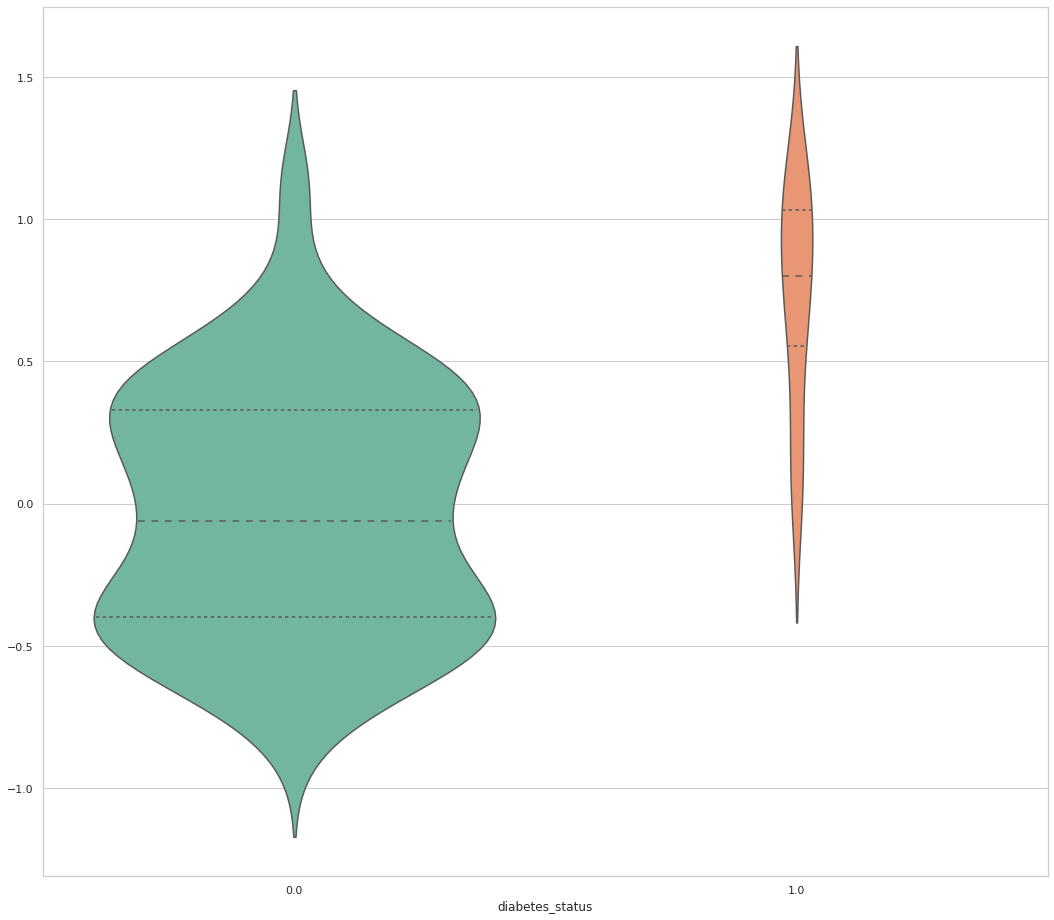

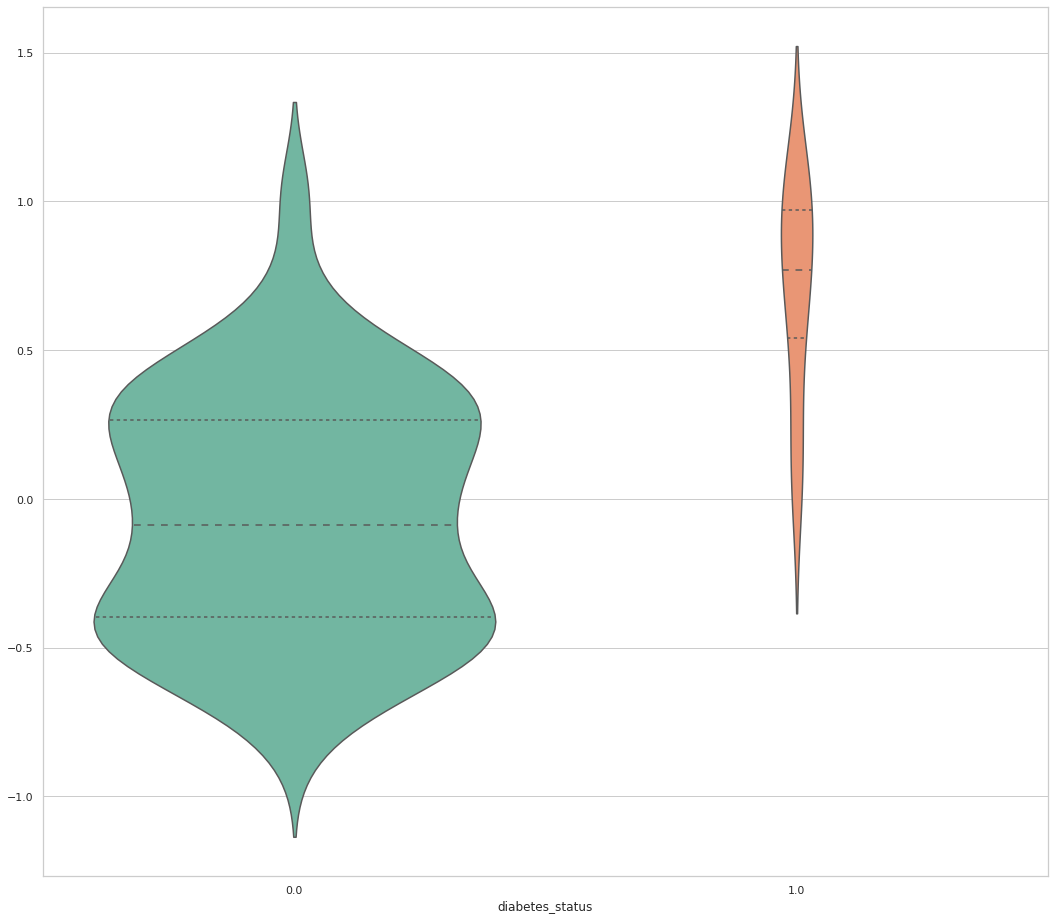

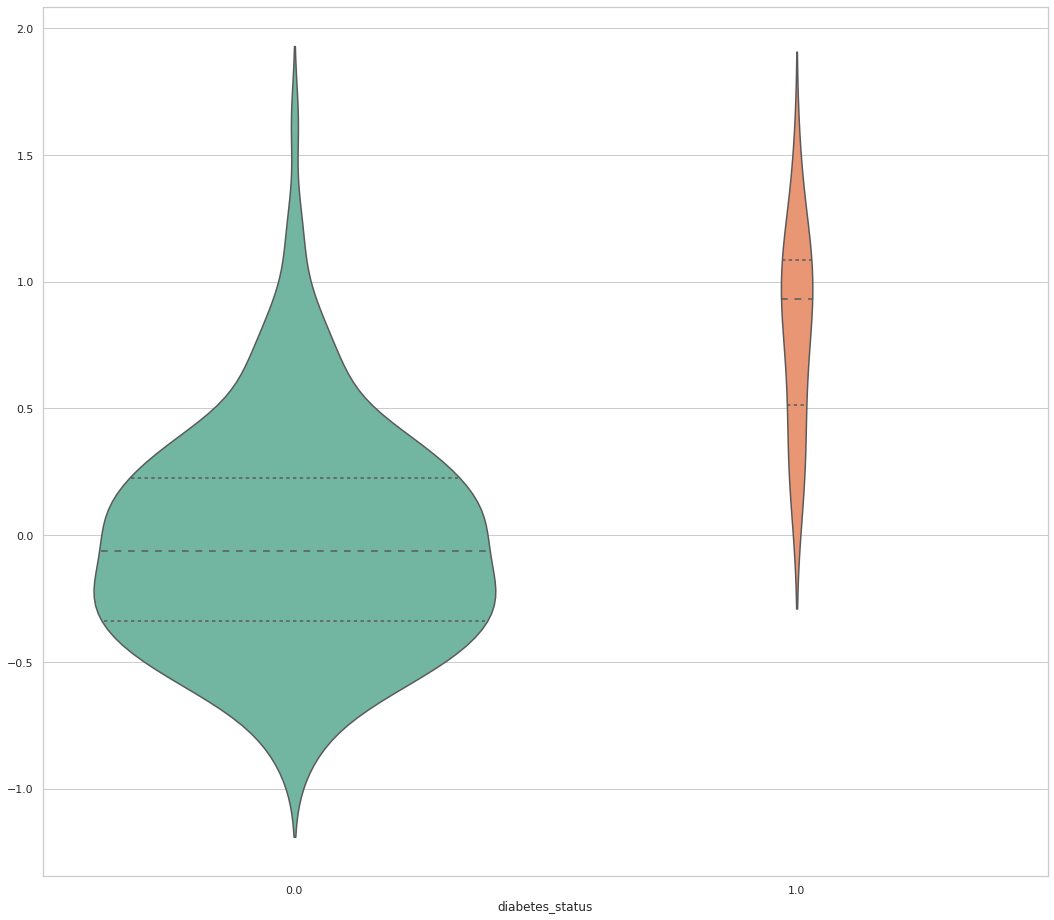

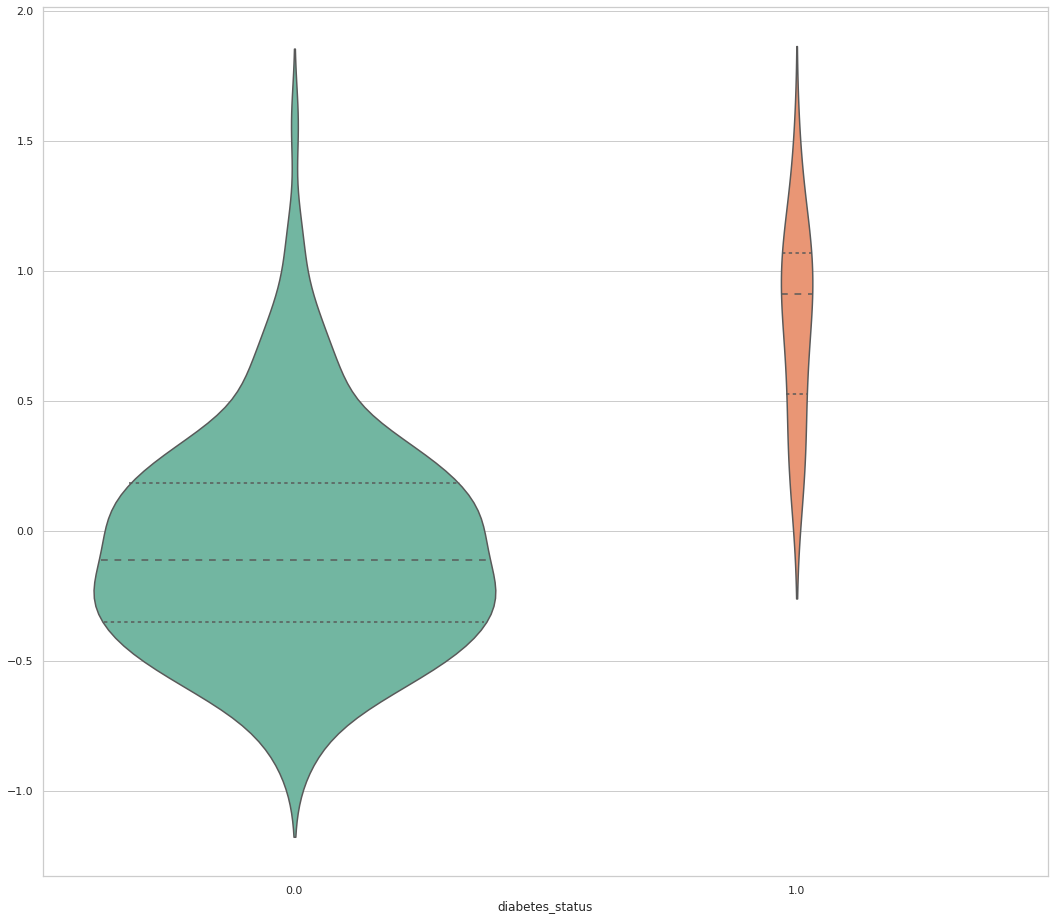

,,,age,sex,bmi_numeric,diabetes_status
MC_dropout_quicknat_seg_spleen_normalised,seg_spleen_normalised,0,0.0189748,0.564771,0.000442475,2.90619e-05
MC_dropout_quicknat_seg_liver_normalised,seg_liver_normalised,0,0.0117663,0.284179,0.242979,9.16504e-08


In [22]:
feats = flatten(feats_from_paper_for_group_test)

dicts = {}
anova_test_dicts = {}
for key, value in model_merged_feats_path_combined.items():
    if 'KORA' in key:
        print('dataset cannot be processed!')
        continue
    print(key)
    df = pd.read_csv(value)
    df = rename(df)
    df = transform_to_categorical(df, ['diabetes_status', 'sex'])
    df, normalised_cols = z_score_column_normalise(df, ['seg_spleen', 'seg_liver'])
    df = df.fillna(0)

    dicts[key] = {}
    anova_test_dicts[key] = {}
    
    target_col = 'seg_spleen_normalised'
    feature_string =  "+".join(feats)

    model = weighted_group_feats(df, target_col, feature_string , 'iou_spleen')
    result = anova_test(model)
    dicts[key][target_col] = model.pvalues[:-1]
    anova_test_dicts[key][target_col] =  result['PR(>F)'].values[:-1]

    target_col = 'seg_liver_normalised'
    model = weighted_group_feats(df, target_col, feature_string , 'iou_liver')
    result = anova_test(model)
    dicts[key][target_col] =  model.pvalues[:-1]
    anova_test_dicts[key][target_col] =  result['PR(>F)'].values[:-1]

p_value_df = df_from_nested_dicts(dicts)
anova_test_p_value_df = df_from_nested_dicts(anova_test_dicts)
p_value_df.columns = feats
anova_test_p_value_df.columns = feats
p_value_df_styler = highlight_significance(p_value_df)
anova_test_p_value_df_styler = highlight_significance(anova_test_p_value_df)
p_value_df_styler

In [ ]:
anova_test_p_value_df_styler

# Normal Mixed Effect Model test

In [ ]:
feats = flatten(feats_from_paper_for_group_test)

li_wts = {'full_bayesian':0.001,
          'full_bayesian_0dot01':0.0001,
          'MC_dropout_quicknat':0.00001,
          'probabilistic_quicknat': 0.0001,
          'hierarchical_quicknat':0.0001
         }
dicts = {}
# anova_test_dicts = {}
for key, value in model_merged_feats_path_combined.items():
    if 'KORA' in key:
        print('dataset cannot be processed!')
        continue
    df = pd.read_csv(value)
    df = rename(df)
    df = transform_to_categorical(df, ['diabetes_status', 'sex'])
    df = df.fillna(0)
    df_s = df.copy()
    df_l = df.copy()

    dicts[key] = {}
#     anova_test_dicts[key] = {}
    feature_string =  "+".join(['1']+feats)
    print(feature_string)
    
    target_col = 'seg_spleen_mlm'
    df_spleen, spleen_normalised_cols_map = z_score_group_normalise(df_s, spleen_sample_cols)
    df_spleen = pre_process_for_mlm(df_spleen, list(spleen_normalised_cols_map.values()), target_col)
    model = normal_mixed_effect_model(df_spleen, target_col, feature_string ,'volume_id')
#     result = anova_test(model)
    dicts[key][target_col] = model.pvalues[:-1]
#     anova_test_dicts[key][target_col] =  result['PR(>F)'].values[:-1]

    target_col = 'seg_liver_mlm'
    df_liver, liver_normalised_cols_map = z_score_group_normalise(df_l, liver_sample_cols)
    df_liver = pre_process_for_mlm(df_liver, list(liver_normalised_cols_map.values()), target_col)
    model = normal_mixed_effect_model(df_liver, target_col, feature_string ,'volume_id')
#     result = anova_test(model)
    dicts[key][target_col] =  model.pvalues[:-1]
#     anova_test_dicts[key][target_col] =  result['PR(>F)'].values[:-1]

p_value_df = df_from_nested_dicts(dicts)
# anova_test_p_value_df = df_from_nested_dicts(anova_test_dicts)
cols = ['intercept']
cols.extend(feats)
p_value_df.columns = cols
# anova_test_p_value_df.columns = feats
p_value_df_styler = highlight_significance(p_value_df)
# anova_test_p_value_df_styler = highlight_significance(anova_test_p_value_df)
p_value_df_styler

# Boxplots and ttest:

In [ ]:
dicts = {}
for key, value in model_merged_feats_path_combined.items():
    print(key)
    df = pd.read_csv(value)
    df = rename(df)
    df = transform_to_categorical(df, ['diabetes_status', 'sex'])
    df, normalised_cols = z_score_column_normalise(df, ['seg_spleen', 'seg_liver'])
    df = df.fillna(0)
    
    dfs = split_diabetes_state(df)
#     plot_and_ttest(dfs, ['normal_seg_spleen_normalised', 'pre_diabetic_seg_spleen_normalised', 'diabetic_seg_spleen_normalised'])
    individual_dicts = plot_and_ttest(dfs, ['normal_seg_liver_normalised', 'pre_diabetic_seg_liver_normalised', 'diabetic_seg_liver_normalised'])
    dicts[key] = individual_dicts
    
p_value_df = pd.DataFrame.from_dict(dicts)   
p_value_df_styler = highlight_significance(p_value_df.T)   


In [ ]:
p_value_df_styler

# Dice vs IOU plots

In [ ]:

for key, value in model_merged_feats_path_combined.items():
    if 'KORA' in key:
        print('dataset cannot be processed!')
        continue
    print(key)
    df = pd.read_csv(value)
    df = rename(df)
    df = transform_to_categorical(df, ['diabetes_status', 'sex'])
    df, normalised_cols = z_score_column_normalise(df, ['seg_spleen', 'seg_liver'])
    df = df.fillna(0)
    
 
    df.plot.scatter(x='dice_mean', y='surface_distance_avg_mean',c='DarkBlue')
    X, y = df['dice_mean'].values.reshape(-1,1),df['surface_distance_avg_mean'].values.reshape(-1,1)
    reg = LinearRegression().fit(X, y)
    print(reg.score(X, y))
    plt.show()
    df.plot.scatter(x='dice_mean', y='iou_mean',c='DarkRed')
    X, y = df['dice_mean'].values.reshape(-1,1),df['iou_mean'].values.reshape(-1,1)
    reg = LinearRegression().fit(X, y)
    print(reg.score(X, y))
    plt.show()

# distribution of diabetes with age

In [ ]:
df = pd.read_csv('./projects/MC_dropout_quicknat/reports/MC_dropout_quicknat_KORA_v2/KORA/10_1572006141.7793334_concat_report_final.csv')
df_fb = pd.read_csv('./projects/full_bayesian/reports/full_bayesian_KORA_v4/KORA/10_1572514598.527084_concat_report_final.csv')

In [ ]:
df['age'].hist(by=df['diabetes_status'])

In [ ]:
df['bmi-numeric'].hist(by=df['diabetes_status'])

In [ ]:
df['sex'].hist(by=df['diabetes_status'])

In [ ]:
df['seg_liver'].hist(by=df['diabetes_status'], bins=30, rot=60 )

In [ ]:
df['seg_liver'].hist(bins=10)

In [ ]:
df[spleen_sample_cols].hist(by=df['diabetes_status'], bins=10)

In [ ]:
df[['iou_liver', 'iou_spleen']].hist(by=df['diabetes_status'], bins=10)

In [ ]:
df[['dice_liver', 'dice_spleen']].hist(by=df['diabetes_status'], bins=10)

In [ ]:
df_fb[['iou_liver', 'iou_spleen']].hist(by=df['diabetes_status'], bins=10)

In [ ]:
df_fb.groupby('diabetes_status')['dice_liver'].hist(bins=10)

In [ ]:
# df_fb['bmi-numeric'].hist(by=df['diabetes_status'], bins=10)
dff = df_fb.groupby('diabetes_status')
dff.mean().T

dff['age'].hist()

In [ ]:
# with pd.option_context('display.max_rows', -1, 'display.max_columns', 5):
#     print(dff.mean().T)
# dff_ = dff.mean().T

for col in df.columns:
    try:
        print(col)
        dff[col].mean().plot()
        plt.show()
    except Exception as e:
        print(e)
        continue

In [ ]:
df['seg_liver_normalised'] = (df['seg_liver'] - df['seg_liver'].min()) / (df['seg_liver'].max()-df['seg_liver'].min())
df['bmi_numeric_normalised'] = (df['bmi-numeric'] - df['bmi-numeric'].min()) / (df['bmi-numeric'].max()-df['bmi-numeric'].min())
df[['seg_liver_normalised', 'bmi_numeric_normalised']].hist(bins=20)

In [ ]:
df[df['seg_spleen']>600000].T

In [ ]:
sample = '/home/abhijit/Jyotirmay/my_thesis/projects/MC_dropout_quicknat/outs/MC_dropout_quicknat_KORA_v2/MC_dropout_quicknat_KORA_v2_predictions_KORA/KORA2453470_seg.nii.gz'
s_data = nb.load(sample).get_fdata()
unique_vals, counts = np.unique(s_data, return_counts=True)
print(counts)

In [ ]:
177461*12